# SGVA-CLIP Fish Pipeline – Inference & Visualization

This notebook implements a 4-stage fish analysis pipeline:

1. **Fish detection – Grounding DINO (Swin-B)**  
   - Text-conditioned detection with prompt `"fish"`.  
   - Output: bounding boxes (YOLO-style yellow boxes + label `fish conf`).
2. **Fish segmentation – SAM-2 (SAM2)**  
   - Uses Grounding DINO bounding boxes as prompts.  
   - Output: blue segmentation masks over the original image.
3. **Fish classification – SGVA-CLIP**  
   - Each segmented fish patch is placed on a white square background and
     classified using CLIP (ViT-H/14, `laion2b_s32b_b79k`) plus the
     visual adapter checkpoint `best_sgva_clip_i2i.pt`.  
   - Output: grey background, white square regions with the fish and
     a label text for each segment.
4. **Fish size estimation – AprilTags, homography & midline**  
   - Uses an AprilTag calibration board and the segmentation masks
     to estimate total length along a smooth midline.  
   - The midline is computed via PCA + 3rd-degree polynomial fit and
     projected via planar homography to obtain fish length in centimetres.  
   - Output: blue masks, red midlines, green AprilTag contours, and
     estimated lengths in centimetres.
---

> **Important (how to run this notebook):**
>
> 1. **Pretrained foundation models are *not* bundled in the supplement**  
>    Grounding DINO, SAM2 and CLIP ViT-H/14 have very large checkpoints, so
>    we do **not** include those `.pth` / `.pt` files here. The notebook
>    contains an *optional* installation/download cell that tries to install
>    dependencies and fetch the correct weights automatically, but whether this cell works depends strongly on your local environment (Python & PyTorch versions, CUDA/CPU, OS, etc.), and it cannot be guaranteed to run unchanged on every system. If the installation cell fails, please install the models manually
>    following the official instructions below and then adjust the paths
>    in the notebook if needed.
> 2. **Where to obtain the models and installation instructions**
>
>    - **Grounding DINO (detection)**  
>      Official repo:  
>      <https://github.com/IDEA-Research/GroundingDINO>  
>      This repository provides installation instructions and links to
>      the pretrained checkpoints (e.g. `groundingdino_swinb_cogcoor.pth`)
>      used in this notebook.
>
>    - **SAM 2 – Segment Anything Model 2 (segmentation)**  
>      Official repo:  
>      <https://github.com/facebookresearch/sam2>  
>      Follow the README to install dependencies and download one of the
>      `sam2` checkpoints (e.g. a `hiera-*` model) and update the path
>      in the notebook if necessary.
>
>    - **CLIP ViT-H/14 – `laion2b_s32b_b79k` (embeddings)**  
>      We use the OpenCLIP implementation with the LAION ViT-H/14 model:
>      - OpenCLIP repo: <https://github.com/mlfoundations/open_clip>  
>      - Model card / weights:  
>        <https://huggingface.co/laion/CLIP-ViT-H-14-laion2B-s32B-b79K>  
>
> If you encounter problems running the notebook or loading the provided
> adapter checkpoint and datasets, please feel free to contact the
> corresponding author; we will gladly help troubleshoot environment-specific
> issues.


In [1]:
# ============================================================
# 1. GLOBAL CONFIGURATION (paths + hyperparameters)
# ============================================================
from pathlib import Path

# Root of this notebook
ROOT = Path.cwd()

# ------------- Input / output folders ------------------------
INPUT_IMAGE_DIR = ROOT / "input_images"
INPUT_IMAGE_DIR.mkdir(parents=True, exist_ok=True)

OUTPUT_DIR = ROOT / "outputs"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Example image used in Parts 1–3
TEST_IMAGE_PATH = INPUT_IMAGE_DIR / "example_fish.jpg"

# ------------- Grounding DINO paths --------------------------
GROUNDINGDINO_REPO_DIR = ROOT / "GroundingDINO"
GROUNDINGDINO_CONFIG   = GROUNDINGDINO_REPO_DIR / "groundingdino" / "config" / "GroundingDINO_SwinB_cfg.py"
GROUNDINGDINO_WEIGHTS  = ROOT / "groundingdino_swinb_cogcoor.pth"

# ------------- SAM-2 paths -----------------------------------
SAM2_REPO_DIR        = ROOT / "segment-anything-2"
SAM2_CHECKPOINT_DIR  = SAM2_REPO_DIR / "checkpoints"
SAM2_CHECKPOINT      = SAM2_CHECKPOINT_DIR / "sam2_hiera_large.pt"
SAM2_CONFIG_NAME     = "sam2_hiera_l.yaml"   # config file name from the repo

# ------------- SGVA-CLIP adapter -----------------------------
SGVA_ADAPTER_PATH = ROOT / "best_sgva_clip_i2i.pt"   # you provide this
CLASS_NAMES_TXT   = ROOT / "class_names.txt"         # optional

# ------------- Hyperparameters (GLOBAL) ----------------------

# Grounding DINO detection thresholds (global)
# Valori allineati allo script che funziona (BOX_THR=0.3, TEXT_THR=0.25, NMS_THR=0.5)
DINO_PROMPT   = "fish"
DINO_BOX_THR  = 0.20   # soglia oggetto
DINO_TEXT_THR = 0.10   # soglia testo
DINO_NMS_THR  = 0.80   # NMS IoU threshold

# SAM-2 segmentation hyper-parameters (replace with your best triple)
SAM2_MASK_THR = 0.5
SAM2_FUSE_IOU = 0.5
SAM2_BOX_EXP  = 12

# Max side length for visualization (images downscaled if needed)
DISPLAY_MAX_SIDE = 2048

# Number of size-evaluation images to preview in Part 4
SIZE_MAX_SHOW = 10

# ------------- Aliases per il codice DINO che funziona -------

# Lo script DINO usa questi nomi:
DATA_FOLDER    = INPUT_IMAGE_DIR
CONFIG_PATH    = GROUNDINGDINO_CONFIG
CHECKPOINT_PATH= GROUNDINGDINO_WEIGHTS

# Soglie usate nello script DINO (uguali ai globali)
BOX_THR  = DINO_BOX_THR
TEXT_THR = DINO_TEXT_THR
NMS_THR  = DINO_NMS_THR

# Device condiviso da tutto il notebook
import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Per coerenza con lo script:
TEXT_PROMPT = DINO_PROMPT

print("Notebook root:", ROOT)
print("Input images directory:", INPUT_IMAGE_DIR)
print("Outputs directory:", OUTPUT_DIR)
print("Example test image path:", TEST_IMAGE_PATH)
print("GroundingDINO config:", GROUNDINGDINO_CONFIG)
print("GroundingDINO weights:", GROUNDINGDINO_WEIGHTS)
print("DEVICE:", DEVICE)
print("DINO BOX_THR / TEXT_THR / NMS_THR:", DINO_BOX_THR, DINO_TEXT_THR, DINO_NMS_THR)


Notebook root: /home/msignaroli/ictiometro/Grounded-Segment-Anything
Input images directory: /home/msignaroli/ictiometro/Grounded-Segment-Anything/marco/plot_3
Outputs directory: /home/msignaroli/ictiometro/Grounded-Segment-Anything/outputs
Example test image path: /home/msignaroli/ictiometro/Grounded-Segment-Anything/marco/plot_3/Arenal_1_1-1-_jpg.rf.d1484f7f074a8721becd64cf8aab23d7.jpg
GroundingDINO config: /home/msignaroli/ictiometro/Grounded-Segment-Anything/GroundingDINO/groundingdino/config/GroundingDINO_SwinB_cfg.py
GroundingDINO weights: /home/msignaroli/ictiometro/Grounded-Segment-Anything/groundingdino_swinb_cogcoor.pth
Size COCO JSON: /home/msignaroli/ictiometro/Grounded-Segment-Anything/marco/pesciometro_size/_annotations.coco.json
DEVICE: cuda
DINO BOX_THR / TEXT_THR / NMS_THR: 0.3 0.25 0.5


In [2]:
# ============================================================
# 1.a · Grounding DINO + SAM‑2 – deps, repo clone, weights download
# ============================================================
import sys, subprocess, urllib.request

def pip_install(pkgs):
    print("Installing:", " ".join(pkgs))
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)

# Core packages for DINO + SAM‑2
for pip_name, import_name in [
    ("torch",           "torch"),
    ("torchvision",     "torchvision"),
    ("opencv-python",   "cv2"),
    ("numpy",           "numpy"),
    ("matplotlib",      "matplotlib"),
    ("huggingface_hub", "huggingface_hub"),
]:
    try:
        __import__(import_name)
    except ImportError:
        pip_install([pip_name])

from pathlib import Path
from huggingface_hub import hf_hub_download

# ---------------- GroundingDINO: repo + weights ----------------
if not GROUNDINGDINO_REPO_DIR.exists():
    print(f"Cloning GroundingDINO into {GROUNDINGDINO_REPO_DIR} ...")
    subprocess.check_call([
        "git", "clone",
        "https://github.com/IDEA-Research/GroundingDINO.git",
        str(GROUNDINGDINO_REPO_DIR),
    ])
else:
    print("GroundingDINO repository already present.")

if not GROUNDINGDINO_WEIGHTS.exists():
    GROUNDINGDINO_WEIGHTS.parent.mkdir(parents=True, exist_ok=True)
    url = (
        "https://github.com/IDEA-Research/GroundingDINO/releases/download/"
        "v0.1.0-alpha2/groundingdino_swinb_cogcoor.pth"
    )
    print("Downloading GroundingDINO Swin‑B weights...")
    urllib.request.urlretrieve(url, GROUNDINGDINO_WEIGHTS)
    print("✓ Downloaded:", GROUNDINGDINO_WEIGHTS)
else:
    print("GroundingDINO weights already present:", GROUNDINGDINO_WEIGHTS)

# ---------------- SAM‑2 (SEM2): repo + checkpoint ---------------
if not SAM2_REPO_DIR.exists():
    print(f"Cloning SAM‑2 repo into {SAM2_REPO_DIR} ...")
    subprocess.check_call([
        "git", "clone",
        "https://github.com/facebookresearch/segment-anything-2.git",
        str(SAM2_REPO_DIR),
    ])
else:
    print("SAM‑2 repository already present.")

SAM2_CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
if not SAM2_CHECKPOINT.exists():
    print("Downloading SAM‑2 Hiera‑L checkpoint via HuggingFace Hub ...")
    hf_hub_download(
        repo_id="facebook/sam2-hiera-large",
        filename="sam2_hiera_large.pt",
        local_dir=str(SAM2_CHECKPOINT_DIR),
    )
    print("✓ Downloaded:", SAM2_CHECKPOINT)
else:
    print("SAM‑2 checkpoint already present:", SAM2_CHECKPOINT)


'\n# ============================================================\n# 1.a · Grounding DINO – dependencies, repo clone, weight download\n# ============================================================\nimport sys, subprocess, pkgutil, urllib.request\n\ndef pip_install(pkgs):\n    print("Installing:", " ".join(pkgs))\n    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)\n\n# Core packages for Part 1\nfor pip_name, import_name in [\n    ("torch", "torch"),\n    ("torchvision", "torchvision"),\n    ("opencv-python", "cv2"),\n    ("numpy", "numpy"),\n    ("matplotlib", "matplotlib"),\n]:\n    try:\n        __import__(import_name)\n    except ImportError:\n        pip_install([pip_name])\n\nfrom pathlib import Path\n\n# Clone GroundingDINO repo if missing\nif not GROUNDINGDINO_REPO_DIR.exists():\n    print(f"Cloning GroundingDINO into {GROUNDINGDINO_REPO_DIR} ...")\n    subprocess.check_call([\n        "git", "clone",\n        "https://github.com/IDEA-Research/Groun

In [3]:
# ============================================================
# 2. Grounding DINO – model, transforms, contain-NMS, helpers
# ============================================================
import torch
from tqdm.auto import tqdm
import sys
import numpy as np
from PIL import Image

# Rende importabile il pacchetto GroundingDINO
sys.path.append(str(GROUNDINGDINO_REPO_DIR))

import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict

# -------------------- CARICA MODELLO -------------------------
def load_model(cfg_path: Path, ckpt_path: Path, device: str = "cpu"):
    """Carica il modello Grounding DINO (logica identica al tuo script)."""
    cfg = SLConfig.fromfile(str(cfg_path))
    cfg.device = device
    model = build_model(cfg)
    ckpt = torch.load(str(ckpt_path), map_location="cpu")["model"]
    model.load_state_dict(clean_state_dict(ckpt), strict=False)
    return model.eval().to(device)

@torch.no_grad()
def forward_dino(model, tensor, caption: str, device: str):
    """Esegue l’inferenza e restituisce (pred_boxes, pred_logits.sigmoid())."""
    cap = caption.lower().strip()
    if not cap.endswith("."):
        cap += "."
    out = model(tensor[None].to(device), captions=[cap])
    # Esattamente come nel tuo script:
    #   pred_boxes: (N,4) cx,cy,w,h norm.
    #   pred_logits: (N,vocab) già sigmoide
    return out["pred_boxes"][0].cpu(), out["pred_logits"].sigmoid()[0].cpu()

def load_image(img_path: Path):
    """Carica un’immagine e la converte in tensore normalizzato per GroundingDINO."""
    img = Image.open(img_path).convert("RGB")
    transform = T.Compose([
        T.RandomResize([800], max_size=1333),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406],
                    [0.229, 0.224, 0.225]),
    ])
    tensor_img, _ = transform(img, None)
    return img.size, img, tensor_img  # size=(W,H), img=originale PIL, tensor=per DINO

def boxes_xyxy(norm_boxes: np.ndarray, size):
    """Converte box normalizzati (cx, cy, w, h) in coordinate xyxy (assolute)."""
    W, H = size
    xc, yc, w, h = norm_boxes.T
    return np.stack([
        (xc - w/2) * W,
        (yc - h/2) * H,
        (xc + w/2) * W,
        (yc + h/2) * H
    ], axis=1)

# -------------------- CONTAIN-NMS ----------------------------
def iou(a, b):
    xx1, yy1 = max(a[0], b[0]), max(a[1], b[1])
    xx2, yy2 = min(a[2], b[2]), min(a[3], b[3])
    inter = max(0, xx2 - xx1) * max(0, yy2 - yy1)
    if inter == 0:
        return 0.0
    area_a = (a[2] - a[0]) * (a[3] - a[1])
    area_b = (b[2] - b[0]) * (b[3] - b[1])
    return inter / (area_a + area_b - inter)

def contain_ratio(sm, bg):
    xx1, yy1 = max(sm[0], bg[0]), max(sm[1], bg[1])
    xx2, yy2 = min(sm[2], bg[2]), min(sm[3], bg[3])
    inter = max(0, xx2 - xx1) * max(0, yy2 - yy1)
    if inter == 0:
        return 0.0
    area_sm = (sm[2] - sm[0]) * (sm[3] - sm[1])
    return inter / area_sm

def contain_nms(boxes, scores, thr):
    """
    Contain-NMS:
      - Sopprime bboxes con IoU > thr se hanno punteggio inferiore
      - Sopprime bboxes "contenuti" (overlap ~100%) se la ratio >= thr
    (copiato identico dal tuo script.)
    """
    if len(boxes) == 0:
        return []
    areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    order = np.argsort(-scores)
    keep = []
    while order.size:
        i = order[0]
        keep.append(i)
        if order.size == 1:
            break
        rest = order[1:]
        sup = []
        for j in rest:
            # iou-based
            if iou(boxes[i], boxes[j]) > thr and scores[j] <= scores[i]:
                sup.append(j)
                continue
            # contain-based
            s, b = (i, j) if areas[i] < areas[j] else (j, i)
            if contain_ratio(boxes[s], boxes[b]) > thr:
                sup.append(b)
        order = np.setdiff1d(rest, sup, assume_unique=True)
    return keep

# -------------------- CARICA MODELLO -------------------------
model = load_model(CONFIG_PATH, CHECKPOINT_PATH, DEVICE)
print("✓ Grounding DINO model loaded on", DEVICE)


/home/msignaroli/miniforge3/envs/env-sem2/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/msignaroli/miniforge3/envs/env-sem2/lib/python3.11/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


/home/msignaroli/miniforge3/envs/env-sem2/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed

✓ Grounding DINO model loaded on cuda


Image size (W,H): (2885, 1788)


/home/msignaroli/miniforge3/envs/env-sem2/lib/python3.11/site-packages/transformers/modeling_utils.py:1101: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/msignaroli/miniforge3/envs/env-sem2/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/msignaroli/miniforge3/envs/env-sem2/lib/python3.11/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/msignaroli/ictiometro/Grounded-Segment-Anything/GroundingDINO/groundingdi


Immagine: Arenal_1_1-1-_jpg.rf.d1484f7f074a8721becd64cf8aab23d7.jpg
  Box 0: [1984, 303, 2594, 526] - score=0.717
  Box 1: [69, 1436, 594, 1566] - score=0.687
  Box 2: [2140, 1294, 2646, 1502] - score=0.682
  Box 3: [989, 781, 1417, 966] - score=0.679
  Box 4: [147, 940, 781, 1166] - score=0.676
  Box 5: [1789, 1489, 2318, 1644] - score=0.676
  Box 6: [2143, 926, 2645, 1128] - score=0.670
  Box 7: [1913, 609, 2692, 923] - score=0.666
  Box 8: [667, 1374, 1216, 1589] - score=0.660
  Box 9: [1393, 821, 1966, 1020] - score=0.659
  Box 10: [649, 656, 969, 1040] - score=0.656
  Box 11: [589, 1096, 1083, 1324] - score=0.651
  Box 12: [1185, 1343, 1774, 1611] - score=0.650
  Box 13: [1085, 1009, 2150, 1361] - score=0.634


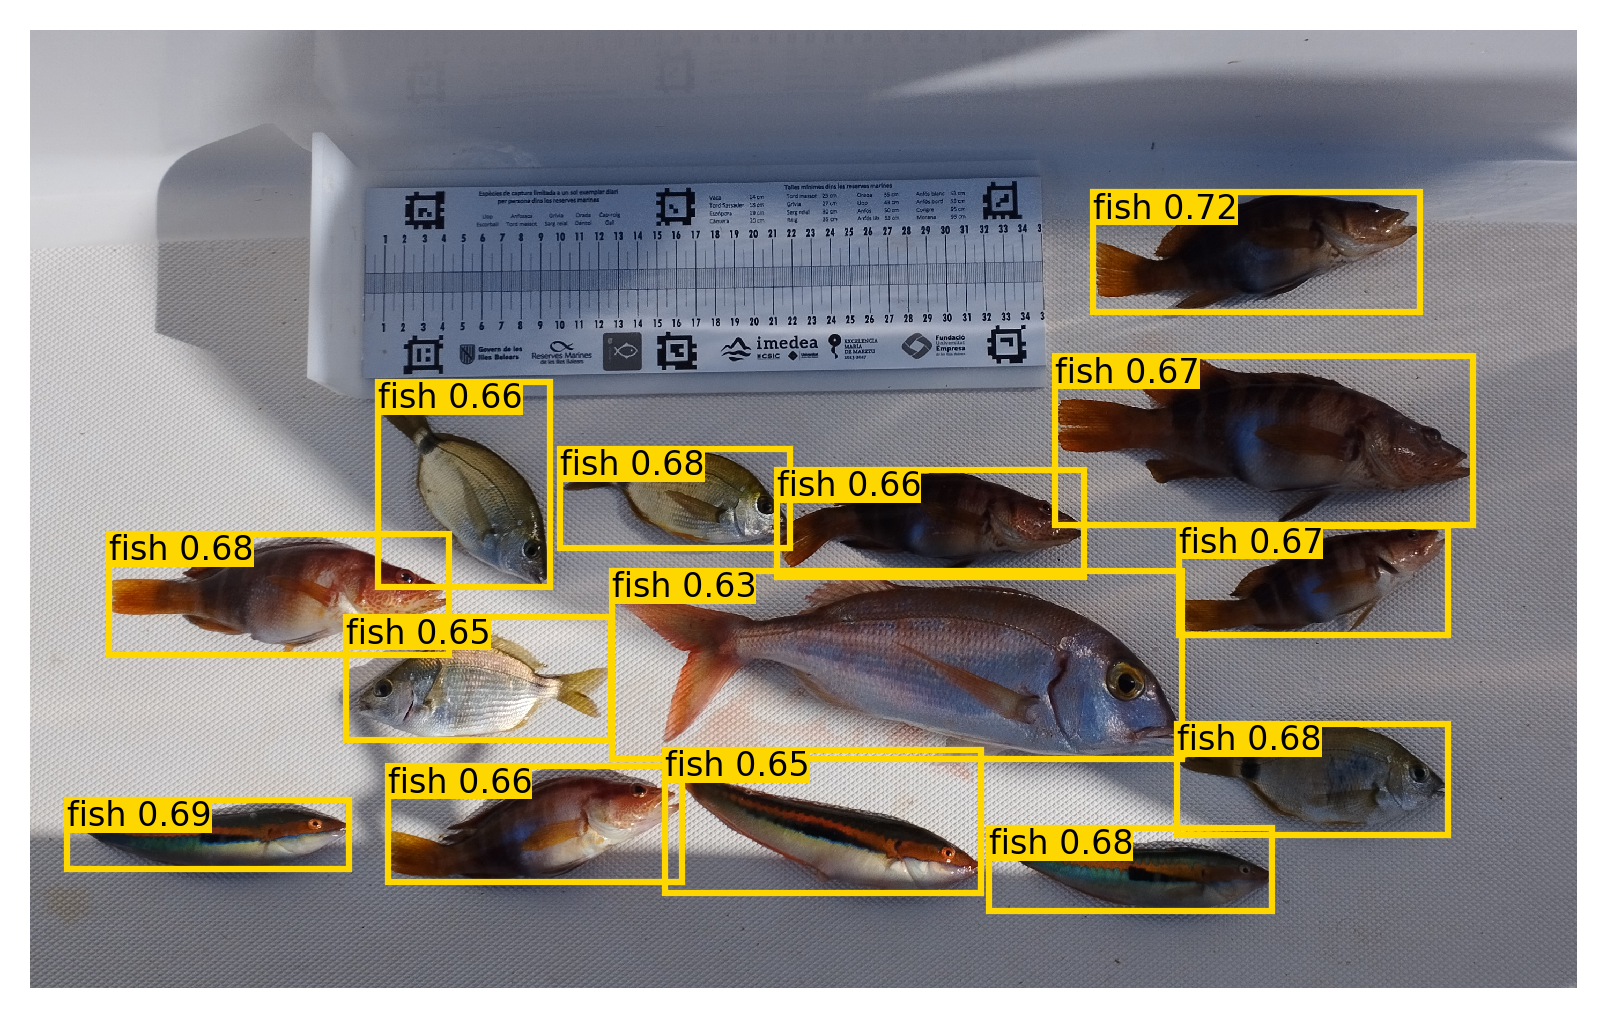

In [4]:
# ============================================================
# 3. Single-image inference + YOLO-style plot
# ============================================================
import matplotlib.patches as patches
import matplotlib.pyplot as plt

BB_COLOR        = "#FFD700"   # gold
LW_BB           = 1.5
TEXT_COLOR      = "black"
TEXT_FS_PT      = 8
OUTPUT_WIDTH_CM = 17
DPI_EXPORT      = 300

def plot_detection_yolo_style(img_pil: Image.Image, boxes_xyxy: np.ndarray, scores: np.ndarray):
    """Plot YOLO-style bounding boxes and 'fish conf' labels."""
    img_np = np.array(img_pil.convert("RGB"))
    h, w = img_np.shape[:2]
    fig_w = OUTPUT_WIDTH_CM / 2.54
    fig_h = (h / w) * fig_w

    fig, ax = plt.subplots(figsize=(fig_w, fig_h), dpi=DPI_EXPORT)
    ax.imshow(img_np, interpolation="none")

    for (x1, y1, x2, y2), sc in zip(boxes_xyxy, scores):
        bw = x2 - x1
        bh = y2 - y1
        # bounding box (gold)
        ax.add_patch(patches.Rectangle(
            (x1, y1), bw, bh,
            fill=False, edgecolor=BB_COLOR, lw=LW_BB
        ))

        # label background + text
        label = f"fish {sc:.2f}"
        ax.text(
            x1, y1, label,
            fontsize=TEXT_FS_PT, color=TEXT_COLOR,
            va="top", ha="left",
            bbox=dict(facecolor=BB_COLOR, alpha=1.0,
                      pad=0.0, edgecolor="none")
        )

    ax.axis("off")
    plt.show()

# ----------------- INFERENCE SU UNA IMMAGINE ----------------
if not TEST_IMAGE_PATH.exists():
    print(f"⚠ TEST_IMAGE_PATH does not exist: {TEST_IMAGE_PATH}")
else:
    size, img_pil, img_tensor = load_image(TEST_IMAGE_PATH)
    print("Image size (W,H):", size)

    # 1) Inference
    norm_boxes, logits = forward_dino(model, img_tensor, TEXT_PROMPT, DEVICE)
    norm_boxes_np = norm_boxes.numpy()
    scores = logits.max(dim=1)[0].numpy()  # max logit per box

    # 2) Filtraggio su box_thr
    idx_box_thr = np.where(scores >= BOX_THR)[0]

    # 3) Filtraggio su text_thr (se QUALSIASI logit > TEXT_THR, il box è valido)
    mask_text = (logits > TEXT_THR).any(1).numpy()
    idx_text_thr = idx_box_thr[mask_text[idx_box_thr]]

    # 4) Conversione in pixel + NMS
    boxes_xy_ = boxes_xyxy(norm_boxes_np, size)        # xyxy float
    sb  = boxes_xy_[idx_text_thr]
    scr = scores[idx_text_thr]

    keep_idx = contain_nms(sb, scr, NMS_THR)
    final_boxes = sb[keep_idx]
    final_scores = scr[keep_idx]

    # 5) Converti in int e clamp (esattamente come nel tuo script)
    final_boxes_int = np.round(final_boxes).astype(int)
    final_boxes_int[:, [0, 2]] = np.clip(final_boxes_int[:, [0, 2]], 0, size[0] - 1)
    final_boxes_int[:, [1, 3]] = np.clip(final_boxes_int[:, [1, 3]], 0, size[1] - 1)

    print(f"\nImmagine: {TEST_IMAGE_PATH.name}")
    if len(final_boxes_int) == 0:
        print("  Nessun box finale dopo filtri e NMS.")
    else:
        for i, (bb, sc) in enumerate(zip(final_boxes_int, final_scores)):
            x1, y1, x2, y2 = bb
            print(f"  Box {i}: [{x1}, {y1}, {x2}, {y2}] - score={sc:.3f}")

    # 6) Plot YOLO-style
    plot_detection_yolo_style(img_pil, final_boxes_int, final_scores)


In [5]:
# ============================================================
# 2.a · SAM‑2 (SEM2) – dependencies, repo clone, checkpoint download
# ============================================================
import sys, subprocess, pkgutil

def pip_install(pkgs):
    print("Installing:", " ".join(pkgs))
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)

# Ensure torch + numpy + matplotlib + opencv are present (should already be)
for pip_name, import_name in [
    ("torch", "torch"),
    ("numpy", "numpy"),
    ("matplotlib", "matplotlib"),
    ("opencv-python", "cv2"),
]:
    try:
        __import__(import_name)
    except ImportError:
        pip_install([pip_name])

# Hugging Face Hub for checkpoint download
try:
    import huggingface_hub  # noqa
except ImportError:
    pip_install(["huggingface_hub"])

from huggingface_hub import hf_hub_download
from pathlib import Path

# Clone SAM‑2 repo if missing
if not SAM2_REPO_DIR.exists():
    print(f"Cloning SAM‑2 repo into {SAM2_REPO_DIR} ...")
    subprocess.check_call([
        "git", "clone",
        "https://github.com/facebookresearch/segment-anything-2.git",
        str(SAM2_REPO_DIR),
    ])
else:
    print("SAM‑2 repository already present.")

# Download Hiera‑L checkpoint if missing
SAM2_CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
if not SAM2_CHECKPOINT.exists():
    print("Downloading SAM‑2 Hiera‑L checkpoint via HuggingFace Hub ...")
    hf_hub_download(
        repo_id="facebook/sam2-hiera-large",
        filename="sam2_hiera_large.pt",
        local_dir=str(SAM2_CHECKPOINT_DIR),
    )
    print("✓ Downloaded:", SAM2_CHECKPOINT)
else:
    print("SAM‑2 checkpoint already present:", SAM2_CHECKPOINT)

SAM‑2 repository already present.
SAM‑2 checkpoint already present: /home/msignaroli/ictiometro/Grounded-Segment-Anything/segment-anything-2/checkpoints/sam2_hiera_large.pt


In [6]:
# ============================================================
# 2.b · SAM‑2 (SEM2) – imports, model, segmentation helpers
# ============================================================
import sys
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import cv2

# Ensure 'device' exists
try:
    device
except NameError:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("device was not defined; using:", device)

# Make SAM‑2 modules importable
sys.path.append(str(SAM2_REPO_DIR))

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Build SAM‑2 model + predictor
sam2_model = build_sam2(SAM2_CONFIG_NAME, str(SAM2_CHECKPOINT), device=device)
sam2_predictor = SAM2ImagePredictor(sam2_model)
print("✓ SAM‑2 model loaded.")

def fuse_masks(bin_masks, thr: float):
    """
    Fuse masks that are too similar (IoU > thr).
    bin_masks: list of boolean arrays (H,W).
    """
    keep = []
    for m in bin_masks:
        if not keep:
            keep.append(m)
            continue
        too_similar = False
        for k in keep:
            inter = np.logical_and(m, k).sum()
            union = np.logical_or(m, k).sum()
            iou   = inter / union if union > 0 else 0.0
            if iou > thr:
                too_similar = True
                break
        if not too_similar:
            keep.append(m)
    return keep

@torch.no_grad()
def sam2_segment_from_boxes(
    img: Image.Image,
    boxes_xyxy: np.ndarray,
    box_expansion: int = SAM2_BOX_EXP,
    mask_threshold: float = SAM2_MASK_THR,
    fuse_iou_thr: float = SAM2_FUSE_IOU,
):
    """
    Segment fish instances from an image given bounding boxes via SAM‑2.

    Parameters
    ----------
    img           : PIL.Image (RGB)
    boxes_xyxy    : (N,4) array of [x1,y1,x2,y2] in pixel coordinates
    box_expansion : integer number of pixels to expand each box
    mask_threshold: threshold on logits to obtain binary masks
    fuse_iou_thr  : IoU threshold for mask fusion

    Returns
    -------
    list of boolean masks (H,W) aligned with the original image.
    """
    img_np = np.array(img.convert("RGB"))
    H, W = img_np.shape[:2]

    if boxes_xyxy is None or len(boxes_xyxy) == 0:
        return []

    boxes = np.array(boxes_xyxy, dtype=np.float32).copy()

    if box_expansion > 0:
        boxes[:, 0] = np.clip(boxes[:, 0] - box_expansion, 0, W - 1)
        boxes[:, 1] = np.clip(boxes[:, 1] - box_expansion, 0, H - 1)
        boxes[:, 2] = np.clip(boxes[:, 2] + box_expansion, 0, W - 1)
        boxes[:, 3] = np.clip(boxes[:, 3] + box_expansion, 0, H - 1)

    sam2_predictor.set_image(img_np)

    if device.startswith("cuda"):
        with torch.autocast("cuda", torch.bfloat16):
            _, _, logit_masks = sam2_predictor.predict(
                box=boxes,
                multimask_output=False,
                return_logits=True,
            )
    else:
        _, _, logit_masks = sam2_predictor.predict(
            box=boxes,
            multimask_output=False,
            return_logits=True,
        )

    mask_logits_list = []
    for l in logit_masks:
        arr = np.asarray(l, dtype=np.float32).squeeze()
        arr_t = torch.from_numpy(arr)[None, None, ...].float()
        arr_resized = F.interpolate(
            arr_t,
            size=(H, W),
            mode="bilinear",
            align_corners=False,
        )
        mask_logits_list.append(arr_resized.squeeze().cpu().numpy())

    bin_masks = [(x >= mask_threshold) for x in mask_logits_list]
    fused_masks = fuse_masks(bin_masks, thr=fuse_iou_thr)
    return fused_masks

def mask_to_square_fish_patch(
    img: Image.Image,
    mask: np.ndarray,
    crop_to_mask: bool = True,
    background_value: int = 255,
) -> Image.Image:
    """
    Apply a binary mask to an RGB image:
      - set background to white,
      - optionally crop to the bounding box of the mask,
      - pad to a square canvas (white background).

    Returns a PIL Image ready to be fed to the classifier.
    """
    img_rgb = img.convert("RGB")
    img_np = np.array(img_rgb)
    H, W = img_np.shape[:2]

    mask_bool = mask.astype(bool)
    if mask_bool.shape != (H, W):
        raise ValueError("Mask shape does not match image size.")

    if not mask_bool.any():
        patch = img_rgb
    else:
        img_np[~mask_bool] = background_value

        if crop_to_mask:
            ys, xs = np.where(mask_bool)
            y_min, y_max = ys.min(), ys.max()
            x_min, x_max = xs.min(), xs.max()
            crop = img_np[y_min:y_max+1, x_min:x_max+1, :]
            patch = Image.fromarray(crop)
        else:
            patch = Image.fromarray(img_np)

    # Pad to square with white background
    w, h = patch.size
    if w == h:
        return patch

    if w > h:
        diff = w - h
        pad_top = diff // 2
        pad_bottom = diff - pad_top
        patch_sq = ImageOps.expand(
            patch,
            border=(0, pad_top, 0, pad_bottom),
            fill=(background_value, background_value, background_value),
        )
    else:
        diff = h - w
        pad_left = diff // 2
        pad_right = diff - pad_left
        patch_sq = ImageOps.expand(
            patch,
            border=(pad_left, 0, pad_right, 0),
            fill=(background_value, background_value, background_value),
        )

    return patch_sq


device was not defined; using: cuda
✓ SAM‑2 model loaded.


Image size (W,H): (2885, 1788)
[Grounding DINO] 14 box(es) after filters + NMS.
  Box 0: [1984, 303, 2594, 526] - score=0.717
  Box 1: [69, 1436, 594, 1566] - score=0.687
  Box 2: [2140, 1294, 2646, 1502] - score=0.682
  Box 3: [989, 781, 1417, 966] - score=0.679
  Box 4: [147, 940, 781, 1166] - score=0.676
  Box 5: [1789, 1489, 2318, 1644] - score=0.676
  Box 6: [2143, 926, 2645, 1128] - score=0.670
  Box 7: [1913, 609, 2692, 923] - score=0.666
  Box 8: [667, 1374, 1216, 1589] - score=0.660
  Box 9: [1393, 821, 1966, 1020] - score=0.659
  Box 10: [649, 656, 969, 1040] - score=0.656
  Box 11: [589, 1096, 1083, 1324] - score=0.651
  Box 12: [1185, 1343, 1774, 1611] - score=0.650
  Box 13: [1085, 1009, 2150, 1361] - score=0.634


/home/msignaroli/miniforge3/envs/env-sem2/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/msignaroli/miniforge3/envs/env-sem2/lib/python3.11/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[SAM-2] 14 mask(s) produced.


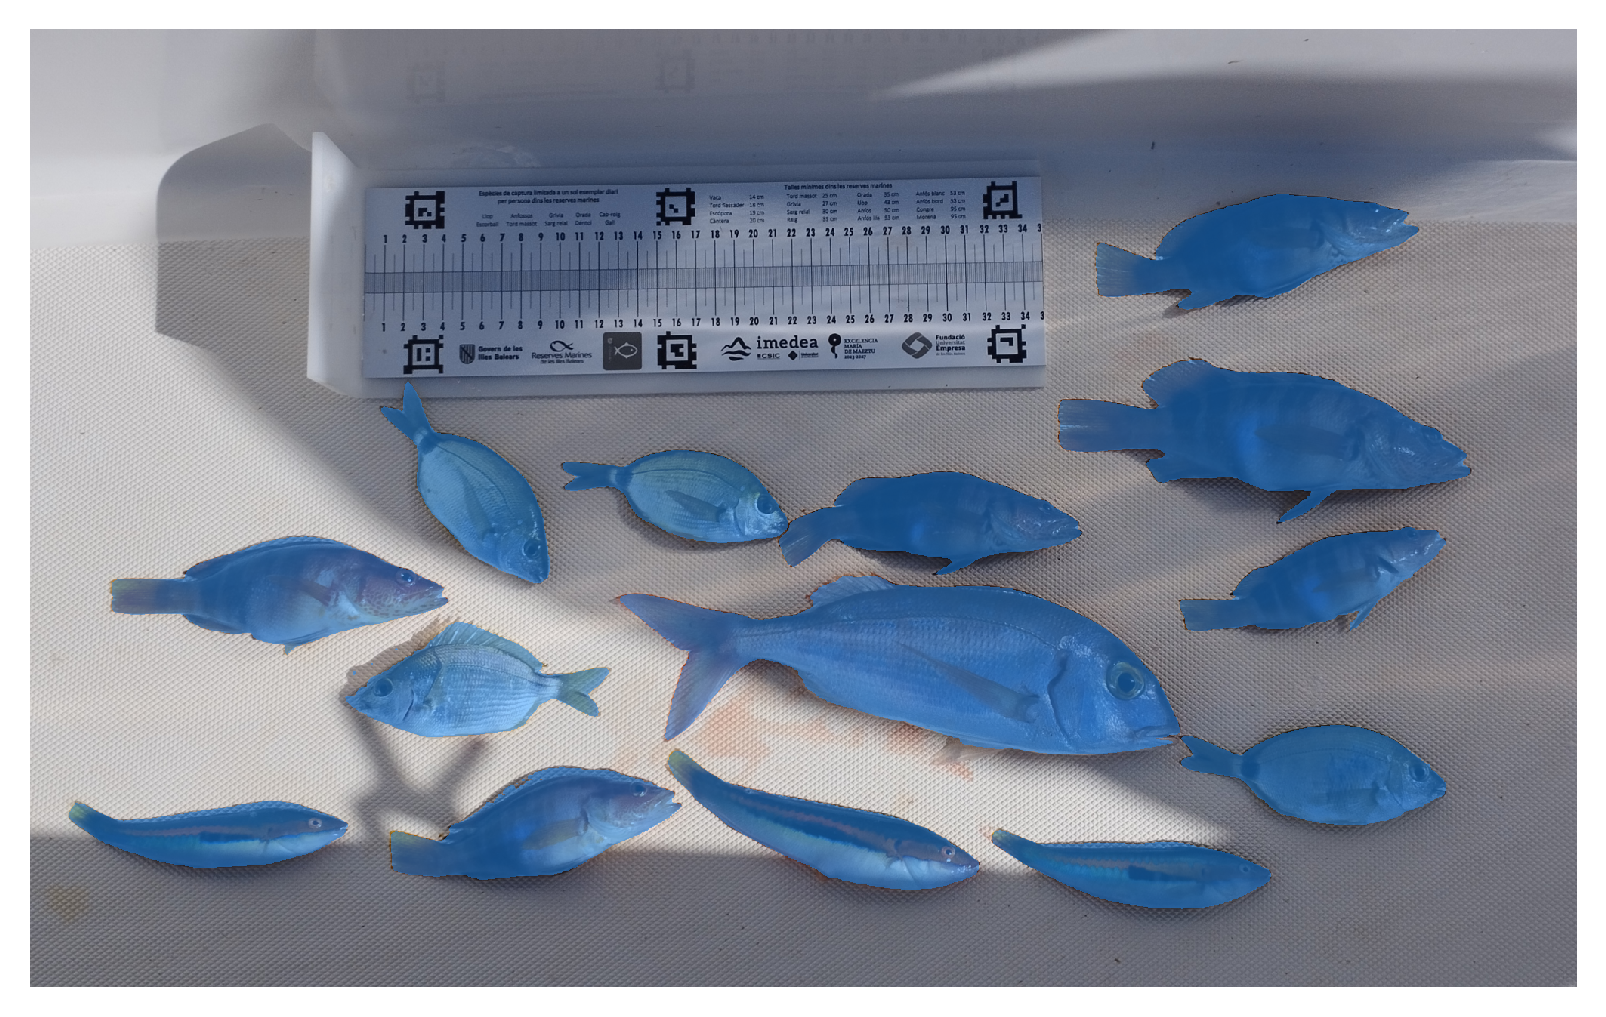

In [7]:
# ============================================================
# 2.c · Example: DINO detection + SAM-2 segmentation (blue masks)
# ============================================================
MASK_COLOR_HEX = "#1E90FF"   # electric blue
ALPHA_MASK     = 0.50

mask_rgb = np.array(
    [int(MASK_COLOR_HEX[i:i+2], 16) for i in (1, 3, 5)]
) / 255.0

OUTPUT_WIDTH_CM = 17
DPI_EXPORT      = 300

def plot_segmentation_blue_overlay(img: Image.Image, masks):
    """Overlay blue masks on top of the original image."""
    img_np = np.array(img.convert("RGB"))
    h, w = img_np.shape[:2]

    # Optional downscale for visualization
    scale = 1.0
    if max(h, w) > DISPLAY_MAX_SIDE:
        scale = DISPLAY_MAX_SIDE / max(h, w)
        new_w, new_h = int(w * scale), int(h * scale)
        img_np = cv2.resize(img_np, (new_w, new_h), interpolation=cv2.INTER_AREA)
    else:
        new_h, new_w = h, w

    overlay_rgb = np.zeros((new_h, new_w, 3), np.float32)
    alpha_layer = np.zeros((new_h, new_w),     np.float32)

    for m in masks:
        m_resized = m
        if m.shape != (new_h, new_w):
            m_resized = cv2.resize(
                m.astype(np.uint8),
                (new_w, new_h),
                interpolation=cv2.INTER_NEAREST
            ).astype(bool)
        overlay_rgb[m_resized] = mask_rgb
        alpha_layer[m_resized] = ALPHA_MASK

    overlay_rgba = np.dstack([overlay_rgb, alpha_layer])

    fig_w = OUTPUT_WIDTH_CM / 2.54
    fig_h = (new_h / new_w) * fig_w

    fig, ax = plt.subplots(figsize=(fig_w, fig_h), dpi=DPI_EXPORT)
    ax.imshow(img_np, interpolation="none")
    ax.imshow(overlay_rgba, interpolation="none")
    ax.axis("off")
    plt.show()

# ----- Run example on TEST_IMAGE_PATH -----------------------
if not TEST_IMAGE_PATH.exists():
    print(f"⚠ Please place a test image at: {TEST_IMAGE_PATH}")
else:
    # 1) Detection con la STESSA logica della cella DINO 3
    size, img_pil, img_tensor = load_image(TEST_IMAGE_PATH)
    print("Image size (W,H):", size)

    # Inference DINO
    norm_boxes, logits = forward_dino(model, img_tensor, TEXT_PROMPT, DEVICE)
    norm_boxes_np = norm_boxes.numpy()
    scores = logits.max(dim=1)[0].numpy()  # max logit per box

    # Filtraggio su box_thr
    idx_box_thr = np.where(scores >= BOX_THR)[0]

    # Filtraggio su text_thr (se QUALSIASI logit > TEXT_THR, il box è valido)
    mask_text = (logits > TEXT_THR).any(1).numpy()
    idx_text_thr = idx_box_thr[mask_text[idx_box_thr]]

    # Conversione in pixel + NMS
    boxes_xy_ = boxes_xyxy(norm_boxes_np, size)        # xyxy float
    sb  = boxes_xy_[idx_text_thr]
    scr = scores[idx_text_thr]

    keep_idx = contain_nms(sb, scr, NMS_THR)
    final_boxes = sb[keep_idx]
    final_scores = scr[keep_idx]

    final_boxes_int = np.round(final_boxes).astype(int)
    final_boxes_int[:, [0, 2]] = np.clip(final_boxes_int[:, [0, 2]], 0, size[0] - 1)
    final_boxes_int[:, [1, 3]] = np.clip(final_boxes_int[:, [1, 3]], 0, size[1] - 1)

    print(f"[Grounding DINO] {len(final_boxes_int)} box(es) after filters + NMS.")
    if len(final_boxes_int) == 0:
        print("  Nessun box finale → SAM-2 non verrà eseguito.")
    else:
        for i, (bb, sc) in enumerate(zip(final_boxes_int, final_scores)):
            x1, y1, x2, y2 = bb
            print(f"  Box {i}: [{x1}, {y1}, {x2}, {y2}] - score={sc:.3f}")

        # 2) SAM-2 segmentation sui box di DINO
        seg_masks = sam2_segment_from_boxes(img_pil, final_boxes_int)
        print(f"[SAM-2] {len(seg_masks)} mask(s) produced.")

        # 3) Plot blu
        plot_segmentation_blue_overlay(img_pil, seg_masks)


In [8]:
# ============================================================
# 3.a · SGVA-CLIP – install open_clip (se serve)
# ============================================================
import sys
import subprocess
import pkgutil

def pip_install(pkgs):
    print("Installing:", " ".join(pkgs))
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)

# open_clip / open_clip_torch
if pkgutil.find_loader("open_clip") is None and pkgutil.find_loader("open_clip_torch") is None:
    try:
        pip_install(["open_clip_torch"])
    except Exception as e:
        print("⚠ Could not install open_clip_torch via pip:", e)
        print("  Please install it manually if not already available.")

# Torch dovrebbe già esserci, ma nel dubbio:
try:
    import torch  # noqa
except ImportError:
    try:
        pip_install(["torch"])
    except Exception as e:
        print("⚠ Could not install torch via pip:", e)
        print("  Please install it manually in your environment.")


In [9]:
# ============================================================
# 3.b · SGVA-CLIP – CLIP backbone, visual adapter, prototypes
# ============================================================
import os
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import open_clip

# Usa lo stesso device globale
try:
    device
except NameError:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("device was not defined; using:", device)

class VisualAdapter(nn.Module):
    """Two-layer MLP with residual scaling (trained on CLIP image features)."""
    def __init__(self, in_dim: int, hidden_dim: int = 1024, dropout_p: float = 0.2):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, in_dim)
        self.dropout = nn.Dropout(p=dropout_p)
        self.wa_new = nn.Parameter(torch.ones(1))
        self.wa_old = nn.Parameter(torch.ones(1))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_new = F.relu(self.fc1(x))
        x_new = self.dropout(x_new)
        x_new = self.fc2(x_new)
        return self.wa_new * x_new + self.wa_old * x

class SGVA_CLIP(nn.Module):
    """Wrapper holding the visual adapter on top of CLIP image features."""
    def __init__(self, in_dim: int, hidden_dim: int = 1024, dropout_p: float = 0.2):
        super().__init__()
        self.visual_adapter = VisualAdapter(in_dim=in_dim, hidden_dim=hidden_dim, dropout_p=dropout_p)

    @torch.no_grad()
    def forward_features(self, feats: torch.Tensor) -> torch.Tensor:
        adapted = self.visual_adapter(feats)
        return F.normalize(adapted, dim=-1)

def cosine_sim(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    a_norm = a / a.norm(dim=-1, keepdim=True)
    b_norm = b / b.norm(dim=-1, keepdim=True)
    return torch.matmul(a_norm, b_norm.t())

# -------- CLIP backbone -------------------------------------
MODEL_NAME = "ViT-H-14"
PRETRAINED = "laion2b_s32b_b79k"

clip_model, _, preprocess_clip = open_clip.create_model_and_transforms(
    MODEL_NAME,
    pretrained=PRETRAINED,
)
clip_model.eval().to(device)
for p in clip_model.parameters():
    p.requires_grad = False

with torch.no_grad():
    dummy = torch.zeros(1, 3, 224, 224).to(device)
    img_dim = clip_model.encode_image(dummy).shape[1]
print("CLIP image embedding dim:", img_dim)

# -------- Adapter + pesi (hidden_dim=1024 per combaciare col checkpoint) ---
adapter = SGVA_CLIP(in_dim=img_dim, hidden_dim=1024, dropout_p=0.2).to(device)

if SGVA_ADAPTER_PATH.exists():
    state = torch.load(SGVA_ADAPTER_PATH, map_location=device)
    adapter.load_state_dict(state)  # shapes ora combaciano
    adapter.eval()
    print("✓ SGVA adapter weights loaded from:", SGVA_ADAPTER_PATH)
else:
    print("⚠ SGVA adapter weights NOT found; classification will use plain CLIP features.")

@torch.no_grad()
def image_to_embedding_for_classification(img: Image.Image, use_adapter: bool = True) -> torch.Tensor:
    """
    Convert a (square) PIL patch to an embedding for classification.
    """
    x = preprocess_clip(img).unsqueeze(0).to(device)
    feats = clip_model.encode_image(x)
    if use_adapter and SGVA_ADAPTER_PATH.exists():
        feats = adapter.forward_features(feats)
    else:
        feats = F.normalize(feats, dim=-1)
    return feats  # [1,D]

# -------- Costruzione prototipi da cartelle dataset ----------

# Path del dataset usato per allenare l'adapter.
# ⚠ MODIFICA QUESTO SE IL TUO DATASET È ALTROVE.
CLASS_DATA_ROOT = Path("/dataset")

print("CLASS_DATA_ROOT:", CLASS_DATA_ROOT)

def gather_images_in_dir(class_dir: Path):
    exts = (".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG")
    return [p for p in class_dir.iterdir() if p.suffix in exts]

@torch.no_grad()
def build_prototypes_from_dataset(
    class_data_root: Path,
    min_images_per_class: int = 20,
    max_images_per_class: int = 50,
):
    """
    Legge le cartelle del dataset originale, costruisce un prototipo
    per ogni classe (media delle embedding delle immagini di quella cartella).

    La logica segue il training:
      - class_names = sorted(os.listdir(data_root))
      - skip classi con < 20 immagini
    """
    if not class_data_root.exists():
        print(f"⚠ CLASS_DATA_ROOT does not exist: {class_data_root}")
        return None, []

    class_dirs = [d for d in class_data_root.iterdir() if d.is_dir()]
    class_dirs = sorted(class_dirs, key=lambda p: p.name)  # stesso ordine del training

    prototypes = []
    class_names = []

    for class_dir in class_dirs:
        imgs = gather_images_in_dir(class_dir)
        if len(imgs) < min_images_per_class:
            # Come nel training: classi con meno di 20 immagini saltate
            continue

        # Usa al massimo max_images_per_class per non esplodere
        imgs = imgs[:max_images_per_class]

        feats = []
        for p in imgs:
            try:
                img = Image.open(p).convert("RGB")
            except Exception as e:
                print(f"  [skip] {p} ({e})")
                continue
            emb = image_to_embedding_for_classification(img, use_adapter=True)  # [1,D]
            feats.append(emb.cpu())

        if not feats:
            continue

        feats = torch.cat(feats, dim=0)                # [N,D]
        proto = feats.mean(dim=0, keepdim=True)        # [1,D]
        proto = F.normalize(proto, dim=-1)             # L2
        prototypes.append(proto)
        class_names.append(class_dir.name)

        print(f"  Class '{class_dir.name}': {len(feats)} imgs → prototype built.")

    if not prototypes:
        print("⚠ No prototypes built (no valid classes).")
        return None, []

    prototypes = torch.cat(prototypes, dim=0).to(device)  # [C,D]
    return prototypes, class_names

# Costruisci (o ricostruisci) i prototipi
PROTOTYPES, CLASS_NAMES = build_prototypes_from_dataset(CLASS_DATA_ROOT)

if PROTOTYPES is not None:
    print(f"\n✓ Built prototypes for {len(CLASS_NAMES)} classes.")
    print("First 5 class names:", CLASS_NAMES[:5])
    print("PROTOTYPES shape:", PROTOTYPES.shape)
else:
    print("⚠ PROTOTYPES is None – check CLASS_DATA_ROOT and dataset contents.")

@torch.no_grad()
def classify_patch_with_prototypes(
    patch: Image.Image,
    prototypes: torch.Tensor,
    class_names,
    top_k: int = 3,
):
    """
    Classifica una patch usando prototipi immagine→immagine (non testo).
    """
    if prototypes is None or len(class_names) == 0:
        raise RuntimeError("Prototypes or class_names not available.")

    img_emb = image_to_embedding_for_classification(patch, use_adapter=True)  # [1,D]
    sims = cosine_sim(img_emb, prototypes).squeeze(0)                         # [C]
    probs = F.softmax(sims, dim=-1).detach().cpu().numpy()
    idx = np.argsort(-probs)[:top_k]
    return [class_names[i] for i in idx], probs[idx].tolist()


CLIP image embedding dim: 1024
✓ SGVA adapter weights loaded from: /home/msignaroli/ictiometro/Grounded-Segment-Anything/best_sgva_clip_i2i.pt
CLASS_DATA_ROOT: /data/pesciometro/destinazione
  Class 'Auxis rochei': 20 imgs → prototype built.
  Class 'Balistes capriscus': 20 imgs → prototype built.
  Class 'Boops boops': 20 imgs → prototype built.
  Class 'Botus podas': 20 imgs → prototype built.
  Class 'Coris julis': 20 imgs → prototype built.
  Class 'Coryphaena hippurus': 20 imgs → prototype built.
  Class 'Dentex dentex': 20 imgs → prototype built.
  Class 'Diplodus annularis': 20 imgs → prototype built.
  Class 'Diplodus sargus': 20 imgs → prototype built.
  Class 'Diplodus vulgaris': 20 imgs → prototype built.
  Class 'Epinephelus marginatus': 20 imgs → prototype built.
  Class 'Euthynnus alletteratus': 20 imgs → prototype built.
  Class 'Labrus merula': 20 imgs → prototype built.
  Class 'Loligo vulgaris': 20 imgs → prototype built.
  Class 'Mullus surmuletus': 20 imgs → prototy

Image size (W,H): (2885, 1788)
[Grounding DINO] 14 box(es) after filters + NMS.
[SAM-2] 14 mask(s) produced.
[Pipeline] 14 fish patch(es) for classification.
Patch #0:
  - Serranus scriba: 0.056
  - Epinephelus marginatus: 0.044
  - Mullus surmuletus: 0.042
Patch #1:
  - Symphodus doderleini: 0.055
  - Coris julis: 0.052
  - Spicara maena: 0.039
Patch #2:
  - Diplodus annularis: 0.050
  - Diplodus sargus: 0.046
  - Spondyliosoma cantharus: 0.034
Patch #3:
  - Diplodus annularis: 0.051
  - Diplodus sargus: 0.046
  - Spondyliosoma cantharus: 0.037
Patch #4:
  - Serranus scriba: 0.055
  - Mullus surmuletus: 0.040
  - Symphodus doderleini: 0.035
Patch #5:
  - Symphodus doderleini: 0.059
  - Coris julis: 0.049
  - Sphyraena sphyraena: 0.036
Patch #6:
  - Serranus scriba: 0.059
  - Serranus cabrilla: 0.038
  - Mullus surmuletus: 0.038
Patch #7:
  - Serranus scriba: 0.057
  - Mullus surmuletus: 0.044
  - Epinephelus marginatus: 0.038
Patch #8:
  - Serranus scriba: 0.059
  - Mullus surmuletus:

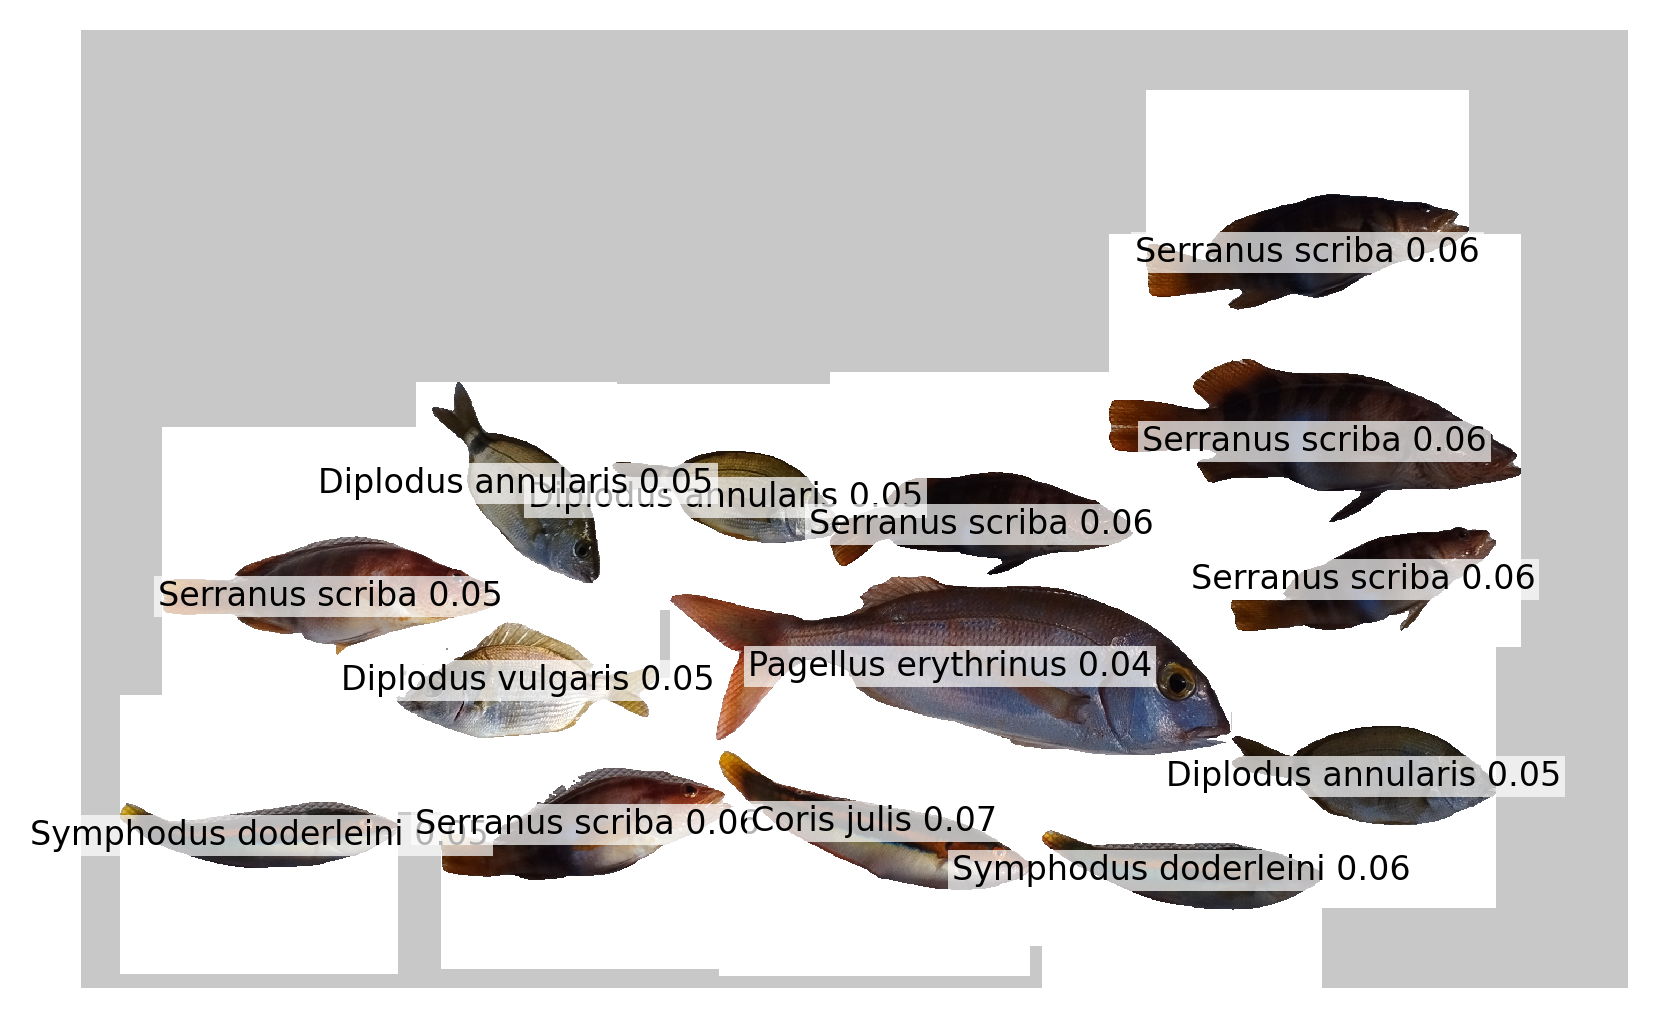

In [10]:
# ============================================================
# 3.c · Example: classification figure (white squares + labels)
# ============================================================
import numpy as np
import matplotlib.pyplot as plt

TXT_FS_PT        = 8
TXT_BOX_ALPHA    = 0.7
OUTPUT_WIDTH_CM  = 17
DPI_EXPORT       = 300

SQUARE_COLOR     = 255   # white
BACKGROUND_COLOR = 200   # light grey

def compute_mask_bboxes(masks):
    """Compute bounding boxes (x, y, bw, bh) from boolean masks."""
    bboxes = []
    for m in masks:
        ys, xs = np.where(m)
        if len(ys) == 0:
            bboxes.append((0, 0, 0, 0))
        else:
            y0, y1 = ys.min(), ys.max()
            x0, x1 = xs.min(), xs.max()
            bw = x1 - x0 + 1
            bh = y1 - y0 + 1
            bboxes.append((x0, y0, bw, bh))
    return bboxes

def plot_classification_patches_square_bg(img: Image.Image, masks, labels):
    """
    Grey canvas, white square regions around each fish, original pixels inside,
    and a text label for each region.
    """
    img_np = np.array(img.convert("RGB"))
    h, w = img_np.shape[:2]

    canvas = np.full_like(img_np, BACKGROUND_COLOR, dtype=np.uint8)
    bboxes = compute_mask_bboxes(masks)

    # White squares
    for (x, y, bw, bh) in bboxes:
        L = int(round(max(bw, bh)))
        cx, cy = x + bw/2, y + bh/2
        x0 = int(round(cx - L/2))
        y0 = int(round(cy - L/2))
        x0 = max(0, x0)
        y0 = max(0, y0)
        x1 = min(w, x0 + L)
        y1 = min(h, y0 + L)
        canvas[y0:y1, x0:x1] = SQUARE_COLOR

    # Paste fish pixels
    for m in masks:
        canvas[m] = img_np[m]

    fig_w = OUTPUT_WIDTH_CM / 2.54
    fig_h = (h / w) * fig_w

    fig, ax = plt.subplots(figsize=(fig_w, fig_h), dpi=DPI_EXPORT)
    ax.imshow(canvas, interpolation="none")

    # Simple center label
    for (x, y, bw, bh), label in zip(bboxes, labels):
        cx, cy = x + bw/2, y + bh/2
        ax.text(
            cx, cy, label,
            fontsize=TXT_FS_PT,
            va="center", ha="center",
            bbox=dict(facecolor="white", alpha=TXT_BOX_ALPHA, pad=1,
                      edgecolor="none"),
            color="black",
        )

    ax.axis("off")
    plt.show()

# ----- Run example on TEST_IMAGE_PATH -----------------------
if not TEST_IMAGE_PATH.exists():
    print(f"⚠ Please place a test image at: {TEST_IMAGE_PATH}")
else:
    if PROTOTYPES is None or len(CLASS_NAMES) == 0:
        raise RuntimeError("PROTOTYPES or CLASS_NAMES not available – run cell 3.b and check CLASS_DATA_ROOT.")

    # 1) Detection DINO (stessa logica di DINO/SEM)
    size, img_pil, img_tensor = load_image(TEST_IMAGE_PATH)
    print("Image size (W,H):", size)

    norm_boxes, logits = forward_dino(model, img_tensor, TEXT_PROMPT, DEVICE)
    norm_boxes_np = norm_boxes.numpy()
    scores = logits.max(dim=1)[0].numpy()  # max logit per box

    # Filtraggio su box_thr
    idx_box_thr = np.where(scores >= BOX_THR)[0]

    # Filtraggio su text_thr (se QUALSIASI logit > TEXT_THR, il box è valido)
    mask_text = (logits > TEXT_THR).any(1).numpy()
    idx_text_thr = idx_box_thr[mask_text[idx_box_thr]]

    # Conversione in pixel + NMS
    boxes_xy_ = boxes_xyxy(norm_boxes_np, size)        # xyxy float
    sb  = boxes_xy_[idx_text_thr]
    scr = scores[idx_text_thr]

    keep_idx = contain_nms(sb, scr, NMS_THR)
    final_boxes = sb[keep_idx]
    final_scores = scr[keep_idx]

    final_boxes_int = np.round(final_boxes).astype(int)
    final_boxes_int[:, [0, 2]] = np.clip(final_boxes_int[:, [0, 2]], 0, size[0] - 1)
    final_boxes_int[:, [1, 3]] = np.clip(final_boxes_int[:, [1, 3]], 0, size[1] - 1)

    print(f"[Grounding DINO] {len(final_boxes_int)} box(es) after filters + NMS.")
    if len(final_boxes_int) == 0:
        print("  Nessun box finale → SAM-2 + classificazione non verranno eseguiti.")
    else:
        # 2) SAM-2 segmentation sui box di DINO
        seg_masks = sam2_segment_from_boxes(img_pil, final_boxes_int)
        print(f"[SAM-2] {len(seg_masks)} mask(s) produced.")

        # 3) Patches per il classificatore
        patches = [mask_to_square_fish_patch(img_pil, m) for m in seg_masks]
        print(f"[Pipeline] {len(patches)} fish patch(es) for classification.")

        # 4) Classification + labels for plot (prototipi immagine→immagine)
        pred_labels_for_plot = []
        for i, patch in enumerate(patches):
            labels_k, probs_k = classify_patch_with_prototypes(
                patch, PROTOTYPES, CLASS_NAMES, top_k=3
            )
            top_label = labels_k[0]
            top_prob  = probs_k[0]
            pred_labels_for_plot.append(f"{top_label} {top_prob:.2f}")
            print(f"Patch #{i}:")
            for lab, pr in zip(labels_k, probs_k):
                print(f"  - {lab}: {pr:.3f}")

        if patches:
            plot_classification_patches_square_bg(img_pil, seg_masks, pred_labels_for_plot)


In [11]:
# ============================================================
# 4.a · Size estimation – imports, style, tag coordinates
# ============================================================
import gc
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
from PIL import Image

from pupil_apriltags import Detector

# ---------- Style parameters (coerenti con codice precedente) ----------
ALPHA_MASK_SIZE   = 0.25
OUTPUT_WIDTH_CM_S = 17
DPI_EXPORT_S      = 300

FONT_SIZE_TXT_PT  = 12
PADDING_TXT_PX    = 4

MIDLINE_COLOR     = "#FF0000"
LW_MIDLINE        = 1.5
MIDLINE_STYLE     = '-'        # solid red midline

TAG_COLOR         = "#00FF00"
LW_TAG            = 1.2

MASK_COLOR_HEX    = "#1E90FF"  # electric blue
mask_rgb_size = np.array(
    [int(MASK_COLOR_HEX[i:i+2], 16) for i in (1, 3, 5)]
) / 255.0

# ---------- Real-world tag coordinates (X,Y in cm) ----------
# (stesse coordinate che usavi nello script di ottimizzazione)
REAL_WORLD_TAG_COORDS = np.array([
    # Tag 0
    [0.4,  2.6], [1.6,  2.6], [1.6,  1.4], [0.4,  1.4],
    # Tag 1
    [0.4, 14.6], [1.6, 14.6], [1.6, 13.4], [0.4, 13.4],
    # Tag 2
    [0.4, 29.6], [1.6, 29.6], [1.6, 28.4], [0.4, 28.4],
    # Tag 3
    [7.8, 29.6], [9.2, 29.6], [9.2, 28.4], [7.8, 28.4],
    # Tag 4
    [7.8, 14.6], [9.2, 14.6], [9.2, 13.4], [7.8, 13.4],
    # Tag 5
    [7.8,  2.6], [9.2,  2.6], [9.2,  1.4], [7.8,  1.4]
], dtype=np.float32)


In [12]:
# ============================================================
# 4.b · Mid-line & homography helpers (PCA + AprilTags)
# ============================================================
import numpy as np
import cv2

def poly_midline(mask: np.ndarray):
    """
    PCA + cubic polynomial fit (degree 3) along the principal axis.

    Parameters
    ----------
    mask : (H,W) boolean array

    Returns
    -------
    list of (r, c) integer coordinates (row, col) of 200 points along the midline.
    """
    pts = np.argwhere(mask > 0)
    if len(pts) < 2:
        return []
    mean = pts.mean(0)
    pts_c = pts - mean
    cov = np.cov(pts_c.T)
    eigvals, eigvecs = np.linalg.eig(cov)
    main = eigvecs[:, eigvals.argmax()]
    main /= np.linalg.norm(main)
    perp = np.array([-main[1], main[0]])
    R = np.vstack([main, perp]).T

    rot = pts_c @ R
    x, y = rot[:, 0], rot[:, 1]
    coef = np.polyfit(x, y, 3)
    xx = np.linspace(x.min(), x.max(), 200)
    yy = np.polyval(coef, xx)
    back = np.column_stack([xx, yy]) @ R.T + mean
    return [(int(r), int(c)) for r, c in back]

def mid_len_cm(path_rc, H):
    """
    Transform mid-line (r,c) points via homography H into (X,Y) in cm
    and sum pairwise distances along the curve.

    Parameters
    ----------
    path_rc : list of (r,c)
    H       : 3x3 homography matrix (pixel -> world)

    Returns
    -------
    total length in cm (float) or None if invalid.
    """
    if H is None or len(path_rc) < 2:
        return None
    pts = np.array([(c, r) for r, c in path_rc], np.float32).reshape(-1, 1, 2)
    real = cv2.perspectiveTransform(pts, H).squeeze()  # (N,2)
    dists = np.linalg.norm(np.diff(real, axis=0), axis=1)
    return float(dists.sum())

def detect_tags(img_rgb: np.ndarray):
    """
    Detect AprilTags (tagStandard41h12) in an RGB image using pupil_apriltags.
    """
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    det  = Detector(
        families="tagStandard41h12",
        nthreads=4,
        quad_decimate=2.0,
        refine_edges=True,
        decode_sharpening=0.25,
    )
    return det.detect(gray)

def compute_scale_factor(H, img_pts, world_pts):
    """
    Compare distances between all pairs of tag corners in world_pts and the
    corresponding corners transformed via H from img_pts.

    Returns mean(real_dist / predicted_dist).
    """
    pts_im  = np.array(img_pts,   np.float32).reshape(-1, 1, 2)
    pts_out = cv2.perspectiveTransform(pts_im, H).reshape(-1, 2)
    pts_w   = np.array(world_pts, np.float32).reshape(-1, 2)

    n = len(pts_w)
    if n < 2:
        return 1.0  # no correction

    ratios = []
    for i in range(n - 1):
        for j in range(i + 1, n):
            dist_real = np.linalg.norm(pts_w[j] - pts_w[i])
            dist_pred = np.linalg.norm(pts_out[j] - pts_out[i])
            if dist_pred > 1e-9:
                ratios.append(dist_real / dist_pred)

    if len(ratios) == 0:
        return 1.0
    return float(np.mean(ratios))

def homography_and_scale(tags):
    """
    Compute homography H (pixel -> world coordinates) and a global scale factor
    based on all corners of detected AprilTags.
    """
    img_pts, world_pts = [], []
    for t in tags:
        for i, c in enumerate(t.corners):
            img_pts.append(c)
            world_pts.append(REAL_WORLD_TAG_COORDS[t.tag_id * 4 + i])
    if not img_pts:
        return None, 1.0

    H, _ = cv2.findHomography(
        np.array(img_pts,   np.float32),
        np.array(world_pts, np.float32)
    )
    if H is None:
        return None, 1.0

    scale_factor = compute_scale_factor(H, img_pts, world_pts)
    return H, scale_factor


Image size (W,H): (2885, 1788)
[Grounding DINO] 14 box(es) after filters + NMS.
[SAM-2] 14 mask(s) produced.
[AprilTags] Detected 6 tag(s).
✓ Homography estimated. Global scale factor: 1.0391943454742432
Fish #0: estimated length = 15.25 cm
Fish #1: estimated length = 14.13 cm
Fish #2: estimated length = 12.08 cm
Fish #3: estimated length = 11.58 cm
Fish #4: estimated length = 16.74 cm
Fish #5: estimated length = 12.82 cm
Fish #6: estimated length = 12.59 cm
Fish #7: estimated length = 19.09 cm
Fish #8: estimated length = 14.37 cm
Fish #9: estimated length = 14.59 cm
Fish #10: estimated length = 12.70 cm
Fish #11: estimated length = 13.07 cm
Fish #12: estimated length = 15.61 cm
Fish #13: estimated length = 26.83 cm


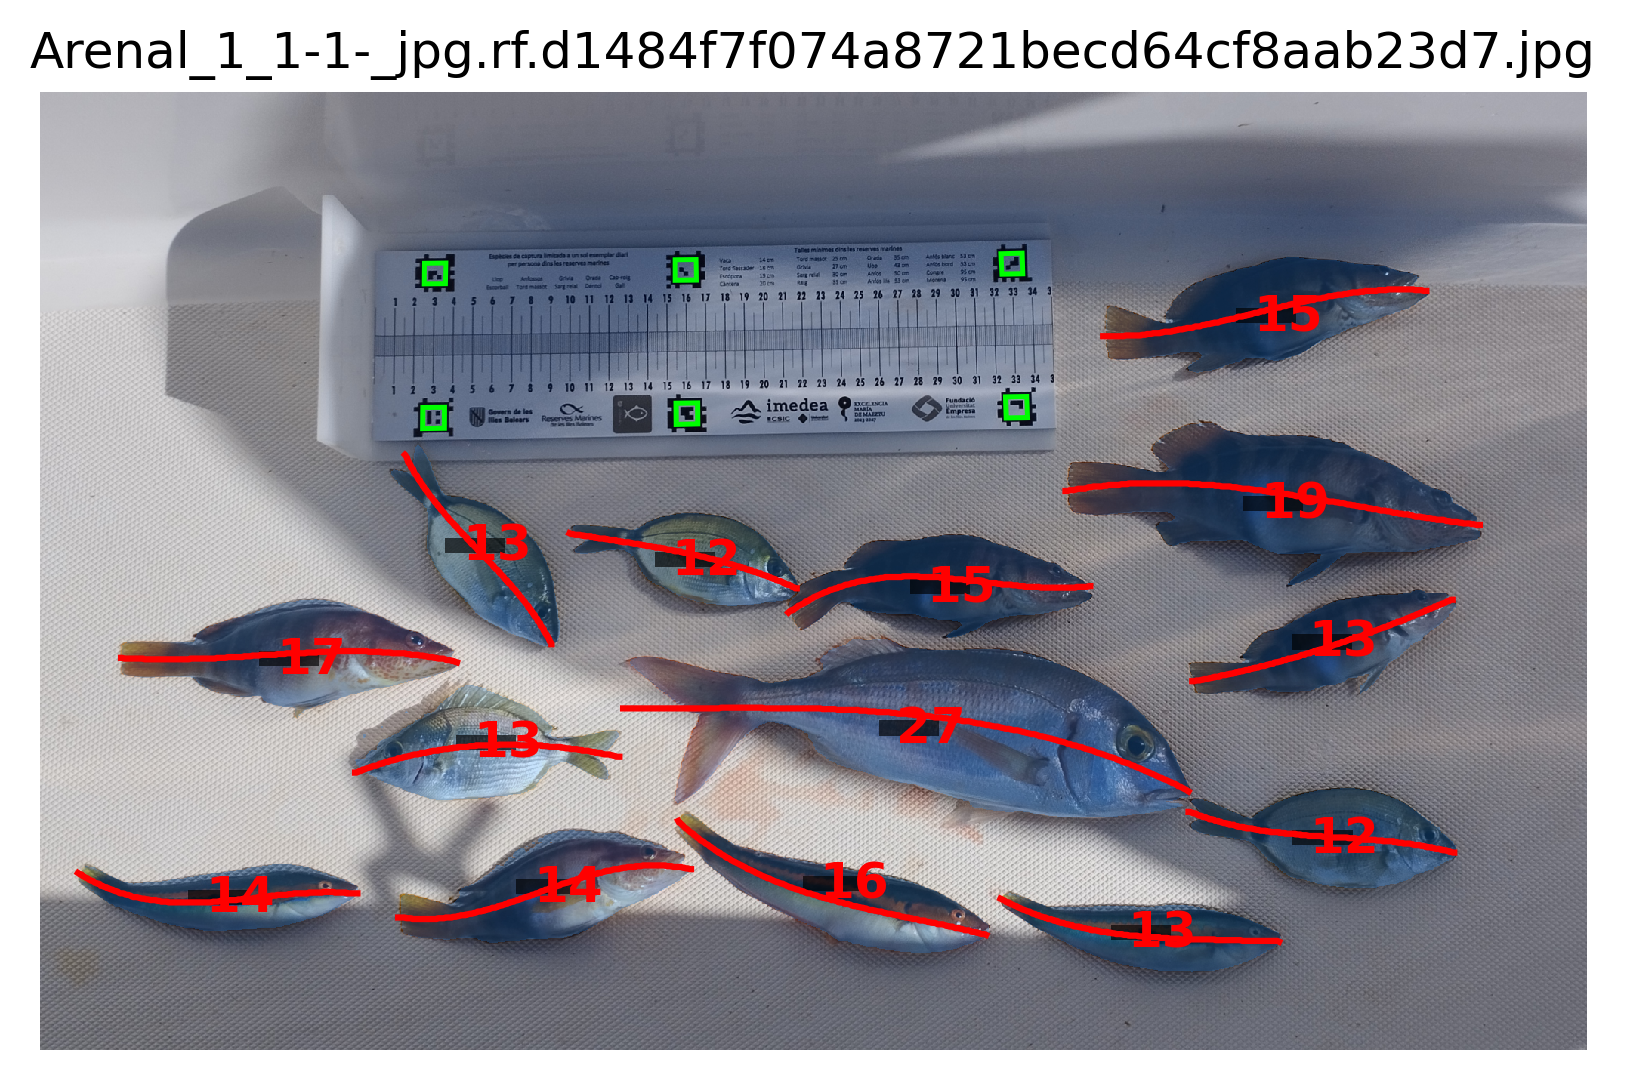

In [13]:
# ============================================================
# 4.c · Example: size estimation on the pipeline image
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from PIL import Image

def estimate_and_plot_size_for_test_image():
    """
    1) Esegue DINO + SAM-2 su TEST_IMAGE_PATH (come nelle parti 2–3).
    2) Rileva gli AprilTag e calcola H + scale_factor.
    3) Per ogni maschera SEM-2:
         - calcola la midline (PCA + polinomio),
         - stima la lunghezza in cm,
         - plottaggio con stile "full blue + midline + tags".
    """
    if not TEST_IMAGE_PATH.exists():
        print(f"⚠ TEST_IMAGE_PATH does not exist: {TEST_IMAGE_PATH}")
        return

    # ---------- 1) Detection DINO + SAM-2 segmentation ----------
    size, img_pil, img_tensor = load_image(TEST_IMAGE_PATH)
    print("Image size (W,H):", size)

    norm_boxes, logits = forward_dino(model, img_tensor, TEXT_PROMPT, DEVICE)
    norm_boxes_np = norm_boxes.numpy()
    scores = logits.max(dim=1)[0].numpy()  # max logit per box

    # Filtraggio su box_thr
    idx_box_thr = np.where(scores >= BOX_THR)[0]

    # Filtraggio su text_thr (se QUALSIASI logit > TEXT_THR, il box è valido)
    mask_text = (logits > TEXT_THR).any(1).numpy()
    idx_text_thr = idx_box_thr[mask_text[idx_box_thr]]

    # Conversione in pixel + NMS
    boxes_xy_ = boxes_xyxy(norm_boxes_np, size)  # xyxy float
    sb  = boxes_xy_[idx_text_thr]
    scr = scores[idx_text_thr]

    keep_idx = contain_nms(sb, scr, NMS_THR)
    final_boxes = sb[keep_idx]
    final_scores = scr[keep_idx]

    final_boxes_int = np.round(final_boxes).astype(int)
    final_boxes_int[:, [0, 2]] = np.clip(final_boxes_int[:, [0, 2]], 0, size[0] - 1)
    final_boxes_int[:, [1, 3]] = np.clip(final_boxes_int[:, [1, 3]], 0, size[1] - 1)

    print(f"[Grounding DINO] {len(final_boxes_int)} box(es) after filters + NMS.")
    if len(final_boxes_int) == 0:
        print("  Nessun box finale → SAM-2 + size estimation non verranno eseguiti.")
        return

    # SAM-2 segmentation sulle box di DINO
    seg_masks = sam2_segment_from_boxes(img_pil, final_boxes_int)
    print(f"[SAM-2] {len(seg_masks)} mask(s) produced.")

    if not seg_masks:
        print("Nessuna maschera dal SEM-2; impossibile stimare la taglia.")
        return

    # ---------- 2) Tag detection + homography + scale ----------
    img_rgb_full = np.array(img_pil.convert("RGB"))
    h0, w0 = img_rgb_full.shape[:2]

    tags_ = detect_tags(img_rgb_full)
    print(f"[AprilTags] Detected {len(tags_)} tag(s).")

    H_, scale_ = homography_and_scale(tags_)
    if H_ is None:
        print("⚠ Homography could not be estimated (no tags or invalid).")
    else:
        print("✓ Homography estimated. Global scale factor:", scale_)

    # ---------- 3) Lunghezza in cm per ogni maschera ----------
    estimated_lengths = []
    midlines_full = []

    for i, m in enumerate(seg_masks):
        mid = poly_midline(m)
        midlines_full.append(mid)
        if H_ is None:
            est_len = None
        else:
            est_len = mid_len_cm(mid, H_)
            if est_len is not None:
                est_len *= scale_
        estimated_lengths.append(est_len)
        print(f"Fish #{i}: estimated length = {('None' if est_len is None else f'{est_len:.2f} cm')}")

    # ---------- 4) Preparazione per la visualizzazione ----------
    # (downscale solo per il plot; le lunghezze sono calcolate a risoluzione originale)
    sc = 1.0
    if max(h0, w0) > DISPLAY_MAX_SIDE:
        sc = DISPLAY_MAX_SIDE / max(h0, w0)
        new_w, new_h = int(w0 * sc), int(h0 * sc)
        img_rgb_vis = cv2.resize(img_rgb_full, (new_w, new_h), interpolation=cv2.INTER_AREA)
    else:
        new_h, new_w = h0, w0
        img_rgb_vis = img_rgb_full.copy()

    # Maschere ridimensionate per l'overlay
    masks_vis = []
    for m in seg_masks:
        if sc != 1.0:
            m_vis = cv2.resize(
                m.astype(np.uint8),
                (new_w, new_h),
                interpolation=cv2.INTER_NEAREST
            ).astype(bool)
        else:
            m_vis = m
        masks_vis.append(m_vis)

    # Midline ridimensionate per il plot
    midlines_vis = []
    for mid in midlines_full:
        if not mid:
            midlines_vis.append([])
            continue
        if sc != 1.0:
            mid_vis = [(int(round(r * sc)), int(round(c * sc))) for (r, c) in mid]
        else:
            mid_vis = mid
        midlines_vis.append(mid_vis)

    # Corner dei tag ridimensionati per il plot
    tags_corners_vis = []
    for t in tags_:
        if sc != 1.0:
            corners = t.corners * sc
        else:
            corners = t.corners
        tags_corners_vis.append(corners)

    # ---------- 5) Overlay e plot finale ----------
    overlay_rgb = np.zeros((new_h, new_w, 3), np.float32)
    alpha_layer = np.zeros((new_h, new_w),     np.float32)

    for m_vis in masks_vis:
        overlay_rgb[m_vis]  = mask_rgb_size
        alpha_layer[m_vis]  = ALPHA_MASK_SIZE

    overlay_rgba = np.dstack([overlay_rgb, alpha_layer])

    fig_w = OUTPUT_WIDTH_CM_S / 2.54
    fig_h = (new_h / new_w) * fig_w
    fig, ax = plt.subplots(figsize=(fig_w, fig_h), dpi=DPI_EXPORT_S)
    ax.imshow(img_rgb_vis, interpolation="none")
    ax.imshow(overlay_rgba, interpolation="none")

    for m_vis, mid_vis, est_len in zip(masks_vis, midlines_vis, estimated_lengths):
        if len(mid_vis) > 1:
            # mid-line rossa
            ax.plot(
                [c for r, c in mid_vis],
                [r for r, c in mid_vis],
                color=MIDLINE_COLOR,
                lw=LW_MIDLINE,
                linestyle=MIDLINE_STYLE,
            )

        # posizione del box di testo: centro del bounding box della maschera
        ys, xs = np.where(m_vis)
        if len(ys) == 0:
            continue
        y_min, y_max = ys.min(), ys.max()
        x_min, x_max = xs.min(), xs.max()
        cx, cy = (x_min + x_max) / 2.0, (y_min + y_max) / 2.0

        txt_ann = "?"   # non abbiamo GT in questa pipeline
        txt_est = "?" if est_len is None else str(int(round(est_len)))

        fs  = FONT_SIZE_TXT_PT
        pad = PADDING_TXT_PX
        gap = 50
        cw   = fs * 0.6
        w_ann = len(txt_ann) * cw
        w_est = len(txt_est) * cw
        width = w_ann + gap + w_est + pad * 2
        height= fs + pad * 2

        rect = patches.Rectangle(
            (cx - width / 2, cy - height / 2),
            width, height,
            facecolor="black", alpha=0.65
        )
        ax.add_patch(rect)

        x_ann = cx - (gap / 2 + w_est / 2)
        x_est = cx + (gap / 2 + w_ann / 2)
        y_txt = cy

        # Rosso = stima
        ax.text(
            x_est, y_txt, txt_est,
            color="red",
            ha="center", va="center",
            fontsize=fs, weight="bold"
        )

    # contorni AprilTag (verde)
    for corners in tags_corners_vis:
        ax.add_patch(patches.Polygon(
            corners, fill=False, color=TAG_COLOR, lw=LW_TAG
        ))

    ax.set_title(TEST_IMAGE_PATH.name)
    ax.axis("off")
    plt.show()
    plt.close(fig)

    return estimated_lengths

# ----- Run example on TEST_IMAGE_PATH -----------------------
estimated_lengths = estimate_and_plot_size_for_test_image()
